In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
dwnload_file = drive.CreateFile({'id':'1urHYahb9NlEWNBOHJXrNg_RCmqOvQNZH'}) #'1TeCPI8sdja_24nvjfsAUe6YgZyQRwBt2'})

In [ ]:
dwnload_file.GetContentFile('shelves_relevant.csv')

In [ ]:
import pandas as pd
shelves_relevant = pd.read_csv('shelves_relevant.csv')
#shelves_relevant.tail()

In [ ]:
# Creation of a modelling dataset


''' We need to aggregate over the 'upc', 'storenum' and 'new_year_mth_wk' ('wks', 'year') codes
in order to obtain the number of out_of_stocks per week
'''


x = ["target_out_stock", "logistic_target", "gross_margin_dollars", "scanned_retail_dollars", "scanned_movement", "profit_unit", "retail_price_unit"]
df = shelves_relevant.groupby(['upc', 'storenum', 'new_year_mth_wk', 'upc_description', "wks", "year"], axis = 0)[x].sum()

shelves_relevant = df.reset_index()
#shelves_relevant.shape
shelves_relevant.index

RangeIndex(start=0, stop=546101, step=1)

In [ ]:
# Checking for negative values in the scanned_retail_dollars column


# We remove this data where it does not affect out_of_stock values --- rationale : these are returns that have not impacted out-of-stock shelves;  we will regard 'returns' as abnormal
# behaviour but to be tolerated.  A negative profit (as indicated by the gross_margin_dollars var.) may be indicative of other factors -- discounts, sales, special events , etc

a = shelves_relevant['scanned_retail_dollars'] < 0
b = shelves_relevant['logistic_target'] > 0

sum(a&b)


0

In [ ]:
shelves_relevant.head()

,upc,storenum,new_year_mth_wk,upc_description,wks,year,target_out_stock,logistic_target,gross_margin_dollars,scanned_retail_dollars,scanned_movement,profit_unit,retail_price_unit
0,1612102200,822,2018 PD 01 WK 1,JK SCRUMPY ORG HRD CD BTL,WK1,2018,0,0,0.0,8.99,1.0,0.0,8.99
1,1612102200,822,2018 PD 01 WK 2,JK SCRUMPY ORG HRD CD BTL,WK2,2018,0,0,0.0,6.99,1.0,0.0,6.99
2,1612102200,822,2018 PD 01 WK 3,JK SCRUMPY ORG HRD CD BTL,WK3,2018,0,0,0.0,6.99,1.0,0.0,6.99
3,1612102200,822,2018 PD 01 WK 4,JK SCRUMPY ORG HRD CD BTL,WK4,2018,0,0,0.0,13.98,2.0,0.0,6.99
4,1612102200,822,2018 PD 02 WK 1,JK SCRUMPY ORG HRD CD BTL,WK1,2018,0,0,0.0,6.99,1.0,0.0,6.99


In [ ]:
# Test and Model set construction and exploration of the modelling dataset
#---------------------------------------------------------------------------


import sklearn
from sklearn.model_selection import train_test_split

XR = shelves_relevant.drop(columns = ['target_out_stock', 'logistic_target']) # explanatory used here is 'logistic_target'


y = shelves_relevant['logistic_target']   # response


XR_train, XR_test, y_train, y_test = train_test_split(XR,y, test_size = .1, random_state = 200, stratify = XR[['storenum', 'wks']]) # Note the stratification



In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
XR_train.to_csv('/content/drive/MyDrive/Beer/XR_train.csv', index = False)

In [ ]:
XR_test.to_csv('/content/drive/MyDrive/Beer/XR_test.csv', index = False)


In [ ]:
y_train.to_csv('/content/drive/MyDrive/Beer/y_train.csv', index = False)

In [ ]:
y_test.to_csv('/content/drive/MyDrive/Beer/y_test.csv', index = False)

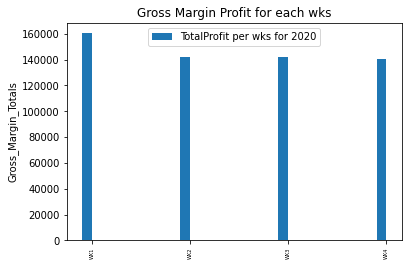

' Note that the ticks without bars in the visualization indicate that data is not available; for the year 2020, the data is available upto the end of October, 2020'

In [ ]:
# Exploration of the Training Set
import numpy as np
''' The categorical variables'''

Z = XR_train[['upc_description', 'storenum', 'wks', 'year','gross_margin_dollars']].groupby(['upc_description', 'storenum', 'wks', 'year']).sum()


Y= Z.reset_index()

''' Visualization of the Gross Margin profit per year for each store. '''

def Gross_Margin(dat , year_param, mode):
   ''' dataset: the input dataset eg., Y
       year_param: the year of interest
       mode: either 'storenum' ,  'upc_description' or 'wks'
   '''

   z = dat[dat['year'] == year_param].groupby([mode])['gross_margin_dollars'].sum()

   z = z.reset_index()

   labels = np.unique(z[mode])

   gross_margin_totalprofit = list(z["gross_margin_dollars"])

   x = np.arange(len(labels))  # the label locations
   width = 0.1  # the width of the bars
   import matplotlib.pyplot as plt
   fig, ax = plt.subplots()
   rects1 = ax.bar(x - width/2, gross_margin_totalprofit, width, label=f'TotalProfit per {mode} for {year_param}')
   ax.set_ylabel('Gross_Margin_Totals')
   ax.set_title(f'Gross Margin Profit for each {mode}')
   ax.set_xticks(x)
   ax.set_xticklabels(labels, fontsize = 5, rotation = 'vertical')
   ax.legend(loc = 'upper center')
   plt.show()

# The input parameter 'year_param' gives the profit for each 'mode'; the 'year_param' ranges over the years covered by the dataset Y
Gross_Margin(dat = Y, year_param = 2020, mode = 'wks')

''' Note that the ticks without bars in the visualization indicate that all data is not available for the year 2020, the data is available upto the end of October, 2020'''

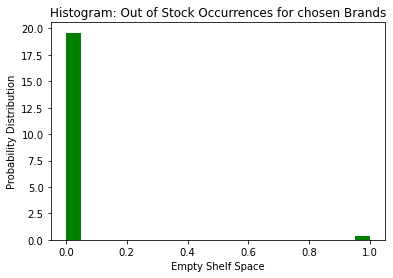

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


ax.hist(np.array(y_train),bins = 'auto', density = True, color = 'green') # plot histogram
ax.set_title("Histogram: Out of Stock Occurrences for chosen Brands")
ax.set_xlabel("Empty Shelf Space")
ax.set_ylabel("Probability Distribution")
plt.show()


In [ ]:
!pip install glmnet

In [ ]:
dir(glmnet)


['ElasticNet',
 'LogitNet',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'errors',
 'linear',
 'logistic',
 'pkg_resources',
 'scorer',
 'util']

In [ ]:
import glmnet
import glmnetPredict


In [ ]:
dir(glmnetPredict)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'glmnetPredict',
 'lambda_interp',
 'nonzeroCoef',
 'scipy',
 'softmax']

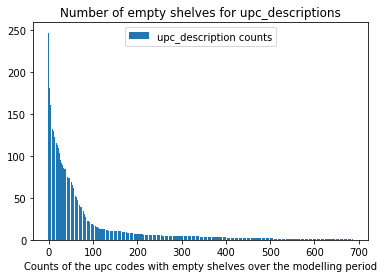

"  upc_dict_legend[5] represents 'STELLA ARTOIS CDR 6PK BTL'  "

In [ ]:
upc_names_counts = XR_train[y_train >= 1]['upc_description'].value_counts()
import matplotlib.pyplot as plt

fig , ax = plt.subplots()
ax.bar(range(len(upc_names_counts)), upc_names_counts, label = 'upc_description counts')
ax.set_title("Number of empty shelves for upc_descriptions")
ax.set_xlabel("Counts of the upc codes with empty shelves over the modelling period")
ax.legend(loc = 'upper center')
plt.show()



''' The dictionary below translates the x-axis values to the upc_description names in the upc_description
    count chart
'''
upc_dict_legend = {i:upc_names_counts._index[i] for i in range(len(upc_names_counts))}

'''  upc_dict_legend[5] represents 'STELLA ARTOIS CDR 6PK BTL'  '''


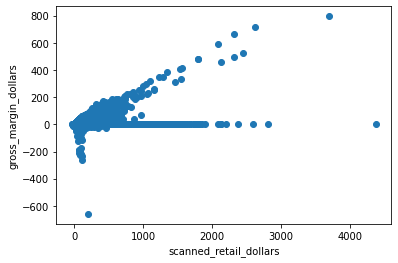

                        scanned_retail_dollars  gross_margin_dollars  \
scanned_retail_dollars                1.000000              0.874924   
gross_margin_dollars                  0.874924              1.000000   
scanned_movement                      0.525671              0.536488   

                        scanned_movement  
scanned_retail_dollars          0.525671  
gross_margin_dollars            0.536488  
scanned_movement                1.000000  


" In this case, we observe that the 'scanned_retail_dollars' is highly correlated with the 'gross_margin_dollars' and both these variables are\n   mildly correlated with 'scanned_movement'\n   The correlation results are not a surprise and in the model we take into account the correlation results.\n"

In [ ]:
''' A plot of the gross_margin_dollars vs. the scanned_retail_dollars indicates many 0 and negative values associated with
gross_margin_dollars possibly indicating sales, promotions, discounts,  etc.
'''

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter( XR_train['scanned_retail_dollars'], XR_train['gross_margin_dollars'])
ax.set_xlabel("scanned_retail_dollars")
ax.set_ylabel('gross_margin_dollars')
plt.show()

# Correlation Analysis of the Numeric Variables
# We first remove cases where the gross_margin_dollars is <= 0 --- possibly due to promotions, discounts etc..

new_grouped = XR_train[XR_train['gross_margin_dollars'] > 0]
correl = new_grouped[['scanned_retail_dollars', 'gross_margin_dollars', 'scanned_movement']].corr(method = 'pearson')
print(correl)

''' In this case, we observe that the 'scanned_retail_dollars' is highly correlated with the 'gross_margin_dollars' and both these variables are
   mildly correlated with 'scanned_movement'
   The correlation results are not a surprise and in the model we take into account the correlation results.
'''

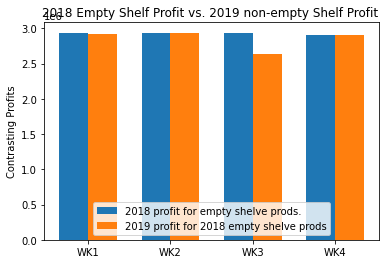

In [ ]:

# This aspect of EDA is NOT correct -- we use the code to illustrate a few techniques
# For each year and week = 1, 2, 3, 4 compare the average profit from those brands that have out-of-stock occurrences in the time period with those that do not have out - of stock occurrences.

#u = XR_train[y_train >=1][['upc_description', 'year', 'wks']].groupby(['year', 'wks']) - a DataframeGroupby object.

def avg_prof_yr_wk(dat ): # dat = XR_train

    u = XR_train[y_train == 1][['upc_description', 'year', 'wks']].groupby(['year', 'wks']) # a DataFrameGroupby object.
    es_amnts = {}
    nes_cmp_amnt = {}

    for i in u.groups.keys():
          names = set(np.array(u.get_group(i)['upc_description']))
          a  = (XR_train[['year', 'wks']]== i).transpose()
          c = (a.prod()).astype(bool)

          d  = (XR_train[c][y_train[c] == 1])['upc_description'].tolist()
          #print(d.shape)
          #s = range(0,1862, 1)
          b = list(np.unique([d[x] for x in range(0, len(d)) if d[x] in list(names)]))
          es_amnts.update({i:round(XR_train[XR_train['upc_description'].isin(b)]['gross_margin_dollars'].sum(), ndigits = 2) })

          f  = (XR_train[['year', 'wks']]== (2019, i[1])).transpose()
          c_2019 = (f.prod()).astype(bool)

          d_2019  = (XR_train[c_2019])['upc_description'].tolist()
          #print(d.shape)
          #s = range(0,1862, 1)
          b_2019 = list(np.unique([d_2019[x] for x in range(0, len(d_2019)) if d_2019[x] in list(names)]))
          nes_cmp_amnt.update({(2019, i[1]):round(XR_train[XR_train['upc_description'].isin(b_2019)]['gross_margin_dollars'].sum(), ndigits = 2) })
    #print(es_amnts, nes_cmp_amnt)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    labels = ['WK1', 'WK2', 'WK3', 'WK4']
    x  = np.arange(len(labels))
    width = .35

    es_2018 = list(es_amnts.values())[:4]
    nes_2019 = list(nes_cmp_amnt.values())
    rects1 = ax.bar(x - width/2, es_2018, width = .35, label = '2018 profit for empty shelve prods.')
    rects2 = ax.bar(x + width/2, nes_2019, width = .35, label = '2019 profit for 2018 empty shelve prods')

    ax.set_title('2018 Empty Shelf Profit vs. 2019 non-empty Shelf Profit ')
    ax.set_ylabel('Contrasting Profits')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(labels = labels)
    ax.legend(loc  =  'lower center')
    plt.show()



    return

avg_prof_yr_wk(dat = XR_train)

In [ ]:
# Summarizing the data by 'upc_description', 'wks', 'storenum':
shelves = shelves_relevant.drop(['logistic_target', 'upc', 'year', 'new_year_mth_wk'], axis = 1)
#shelves.shape
#df = shelves.groupby(['upc_description', 'storenum', 'wks']).sum(['scanned_retail_dollars', 'gross_margin_dollars', 'scanned_movement', 'target_out_stock']) # independent of year
df_group_mean = shelves.groupby(['upc_description', 'storenum', 'wks']).mean(['scanned_retail_dollars', 'gross_margin_dollars', 'scanned_movement', 'profit_unit', 'retail_price_unit', 'target_out_stock'])
df_group_mean.reset_index(level = ['upc_description', 'storenum', 'wks'], inplace = True)
#print(df_group_mean.shape)

df_group_mean.dropna(axis = 0, inplace = True)
print(df_group_mean.shape)
#shelves_pois = df.reset_index(level = ['upc_description', 'storenum', 'wks'])
#print(shelves_pois.shape)
#shelves_pois = shelves_pois.dropna(axis = 0 , inplace = True)
#shelves_pois.index

(21636, 9)


In [ ]:

a = df_group_mean.isnull() # [['scanned_retail_dollars', 'gross_margin_dollars', 'scanned_movement','target_out_stock']].isnull()
#a.head()
max( [any(a.iloc[i, :]) for i in range(0, 21648)])

True

In [ ]:
df_group_mean.dropna(axis = 0, inplace = True)

In [ ]:
df_group_mean.shape
X = df_group_mean.drop(['target_out_stock'], axis = 1)
y = df_group_mean['target_out_stock']
X.groupby(['storenum', 'wks']).size()

storenum  wks
101       WK1    118
          WK2    118
          WK3    118
          WK4    118
105       WK1    108
                ... 
891       WK4     80
894       WK1     31
          WK2     31
          WK3     31
          WK4     31
Length: 256, dtype: int64

In [ ]:
# Construction of a training and test set
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split # StratifiedKfold
X_usw_train , X_usw_test,y_usw_train, y_usw_test= sk.model_selection.train_test_split(X, y, test_size = .1,random_state = 100, stratify = X[['storenum', 'wks']])
#X_usw_train.shape
#print(f'non_zero:{y_usw_train[y_usw_train > 0].count()} and zero :{y_usw_train[y_usw_train == 0].count()}')
print(X_usw_train.shape, X_usw_test.shape)


(19472, 8) (2164, 8)


In [ ]:
print(X_usw_train.info(), X_usw_test.info())


In [ ]:
############################################ Encoding of the Categorical Variables ################################



# OneHotEncoder
# Used when constructing a design matrix needed for use in  the API 'statsmodels' - the matrices have changed indices
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop = 'first') # instantiation
df = {'df_0':X_usw_train, 'df_1':X_usw_test}
df_mdl = {}
for val in range(0,2, 1):

    ohe_rslts = ohe.fit_transform(df[f'df_{val}'][['wks', 'upc_description', 'storenum']])
    colnames = list(df[f'df_{val}']['wks'].unique()[1:]) + list(df[f'df_{val}']['upc_description'].unique()[1:])+ ["st" + str(x) for x in list(df[f'df_{val}']['storenum'].unique()[1:])]
    x = pd.DataFrame(ohe_rslts.toarray(),columns = colnames )
    #x = x.dropna(axis = 0) # in fact all rows are non-empty
    x.index = df[f'df_{val}'].index
    print(x.index)
    df_mdl[f'df_mdl_{val}'] = x

#print(df_mdl['df_mdl_0'].shape)
#print(df_mdl['df_mdl_0'].index)


Int64Index([15865, 12204,   889, 16450,  4092, 19231, 18799,  8052, 10306,
            19654,
            ...
             4280,   741, 21096,  5771, 10399,  5183, 11009, 12875,  2494,
             7356],
           dtype='int64', length=19472)
Int64Index([ 1946, 14037, 16125,  6017,  3468,  3760,  9723, 19755, 20569,
            17427,
            ...
             1437, 15537,  7298, 12761,  4079, 10506,  3606, 16923,  6271,
            18956],
           dtype='int64', length=2164)


In [ ]:
#df_mdl['df_mdl_1'].columns[0:3]
df['df_0'].index

Int64Index([15865, 12204,   889, 16450,  4092, 19231, 18799,  8052, 10306,
            19654,
            ...
             4280,   741, 21096,  5771, 10399,  5183, 11009, 12875,  2494,
             7356],
           dtype='int64', length=19472)

In [ ]:
# Normalization (Standard) applied to the numeric variables in the Training Set.

# Usual Normalize - (remove mean and divide by standard deviation -- standard technique)
norm_dict = {}
for val in range(0, 2, 1):
     m_std_norm = df[f'df_{val}'][['scanned_retail_dollars', 'gross_margin_dollars', 'scanned_movement']].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
     #print(m_std_norm.index)
     norm = pd.DataFrame(m_std_norm)
     norm_dict[f'norm_{val}'] = norm
print(norm_dict["norm_0"].shape)
norm_dict["norm_0"].index

(19472, 3)


Int64Index([15865, 12204,   889, 16450,  4092, 19231, 18799,  8052, 10306,
            19654,
            ...
             4280,   741, 21096,  5771, 10399,  5183, 11009, 12875,  2494,
             7356],
           dtype='int64', length=19472)

In [ ]:
 print(X_usw_train.index)
 #print(m_std_norm.index)

Int64Index([15865, 12204,   889, 16450,  4092, 19231, 18799,  8052, 10306,
            19654,
            ...
             4280,   741, 21096,  5771, 10399,  5183, 11009, 12875,  2494,
             7356],
           dtype='int64', length=19472)


In [ ]:
# Training/Test datasets --e.g. XR_mdl_Train for use in the API 'statsmodels'
X_usw_mdl = {"T0": '', "T1":''}
for val in range(0, 2, 1):

       a = norm_dict[f'norm_{val}']
       X_usw_mdl[f"T{val}"] = df_mdl[f'df_mdl_{val}'].merge(a, how = 'inner', on = a.index,  left_index= False, right_index = False)
#XR_mdl_train = XR_mdl_train.drop(columns = ['key_0'])
#XR_mdl_train.head()
X_usw_mdl["T0"].shape

(19472, 775)

In [ ]:
X_usw_mdl['T0'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            19462, 19463, 19464, 19465, 19466, 19467, 19468, 19469, 19470,
            19471],
           dtype='int64', length=19472)

In [ ]:
u = X_usw_mdl['T0']
u.head()

,key_0,WK2,WK4,WK3,ICEHOUSE CAN,ALASKAN IPA 6PK BTL,PFRIEM CLASSC PILS 6P CN,BUD LIGHT LM RTA CAN,SPRIE MT DRK&DRY APL BTL,SLVR CTY RDGTP RED 6P CAN,...,st207,st881,st883,st855,st828,st856,st873,scanned_retail_dollars,gross_margin_dollars,scanned_movement
0,15865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055850,1.034952,0.242064
1,12204,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.605298,-0.650914,0.271574
2,889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.598459,-0.650914,-0.590121
3,16450,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.115589,-0.650914,0.903090
4,4092,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.336506,0.597125,0.861776


**At this point various models are tried: **

# Models:
> Poisson,
> Normal,
> Tweedie ( compound Poisson-Gamma),
> AdaBoost,
> Random Forests






---


In [ ]:
# Poisson Regressor
# As of writing glmnet versin 2.2.1 does not have an implementation for Poisson GLM
!pip install statsmodels

from statsmodels.discrete  import discrete_model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
y_usw_train.index




NameError: ignored

In [ ]:
import numpy as np
import statsmodels.api as sm

X_usw_mdl_train_w_intcept = sm.add_constant(X_usw_mdl['T0'])
#print(X_usw_mdl_train_w_intcept.shape)

print(X_usw_mdl_train_w_intcept.shape, y_usw_train.index)
a = X_usw_mdl_train_w_intcept.merge(y_usw_train.to_frame(), how  = 'inner',left_index = True, right_index = True)
print(a.shape)
b = a.dropna(axis = 0)
print(b.shape)
#y_usw_train = b['target_out_stock']
#X_usw_mdl_train_w_intcept = b.drop(axis = 1, labels = ['target_out_stock'])
#print(len(y_usw_train), X_usw_mdl_train_w_intcept.shape)
import matplotlib.pyplot as plt
fig , ax = plt.subplots()
ax.hist(y_usw_train, bins = 10, label = 'target_out_stock')
ax.legend()
plt.show()

In [ ]:
# Checking the non-singularity of the Design Matrix
poisson_model = sm.GLM(np.array(y_usw_train), np.array(X_usw_mdl_train_w_intcept), family=sm.families.Poisson())
u, s, vt = np.linalg.svd(poisson_model.exog, 0)

print(u, s, vt)

# Note : A singular value (last in the diagonal matrix) is very small ( ~ e-10)
# therefore decision to use the 'elastic_net' method -- related to ridge regression --- introducing some bias.


In [ ]:
poisson_results = poisson_model.fit_regularized(method = "elastic_net", alpha = .1)

dir(poisson_results)

In [ ]:
yhat = poisson_results.fittedvalues
#max_yhat =yhat.max()
from statsmodels.graphics.api import abline_plot
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax = plt.subplots(2,2)

ax[0, 0].scatter(y_usw_train, yhat)
line_fit = sm.OLS(y_usw_train, sm.add_constant(yhat, prepend = True)).fit()
abline_plot(model_results=line_fit, ax=ax[0,0])
ax[0, 0].set_title('Model Fit Plot')
ax[0, 0].set_xlabel('Observed values')
ax[0, 0].set_ylabel('Fitted values')
n_bins = 10
ax[0, 1].hist(y_usw_train, bins = n_bins, density = True, color = 'green')
ax[0, 1].set_title("Observed Training Target")
X_usw_mdl_w_intcept_test = sm.add_constant(X_usw_mdl['T1'])
y_usw_pred_test = poisson_results.predict(X_usw_mdl_w_intcept_test)

ax[1, 0].scatter(y_usw_test, y_usw_pred_test)
ax[1, 0].plot(y_usw_test, y_usw_test, color = 'green')
#ax[1, 1].hist(y_usw_pred_test, bins = 10, density = True, color = None)
ax[1,1].set_title("Observed Test Target")
ax[1, 1].hist(y_usw_test, bins = n_bins, density = True, edgecolor = 'white', color = 'green')
plt.show()


In [ ]:
# Raw mean and variance
a = shelves.groupby(['upc_description', 'wks', 'storenum'])['target_out_stock'].sum()
print(a.mean(), a.var())


In [ ]:
a = X_usw_mdl_train.merge(y_usw_train, how  = 'inner', left_index = True , right_index = True)
b = a.dropna(axis = 0)
print(b.shape)
y_usw_train = b['target_out_stock']
X_usw_mdl_train = b.drop(axis = 1, labels = ['target_out_stock'])

In [ ]:
# Exploring various power ( variance power or "tweedie_power") options for the Tweedie Distribution
# Calculating the deviances that result from the model that uses each 'power' number  in "tweedie_power"
from sklearn import linear_model
from sklearn.metrics import mean_tweedie_deviance
tweedie_power = [0,1, 1.2, 1.4, 1.7, 1.9]
dev = []
for tp in tweedie_power:
     clf = linear_model.TweedieRegressor(fit_intercept =True, power = tp)
     clf.fit(X_usw_mdl_train, y_usw_train)
     y_usw_pred = clf.predict(X_usw_mdl_train)
     dev.append(mean_tweedie_deviance(y_usw_train, y_usw_pred, power = tp))
dev

In [ ]:
# The Normal Distribution ( variance_power = 0) has the lowest deviance
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax = plt.subplots(1,2)

#for tp in tweedie_power:
clf = linear_model.TweedieRegressor(fit_intercept = True, power = 0)
clf.fit(X_usw_mdl_train, y_usw_train)
y_usw_pred_trn = clf.predict(X_usw_mdl_train)
ax[0].plot(y_usw_train, y_usw_pred_trn, 'o', color = 'red')
#clf2 = linear_model.LinearRegression(fit_intercept = False)
#clf2.fit(y_usw_train, y_usw_pred)
ax[0].plot(y_usw_train,y_usw_train, color = 'green')
ax[0].set_ylabel("prediction")
ax[0].set_xlabel("observation")
ax[0].set_title("Train: Pred vs Obs, Normal D")

#clf.fit(X_usw_mdl_test, y_usw_test)
y_usw_pred_tst = clf.predict(X_usw_mdl_test)
ax[1].plot(y_usw_test, y_usw_pred_tst, 'o', color = 'red')
#clf2 = linear_model.LinearRegression(fit_intercept = False)
#clf2.fit(y_usw_train, y_usw_pred)
ax[1].plot(y_usw_test,y_usw_test, color = 'green')
ax[1].set_ylabel("prediction")
ax[1].set_xlabel("observation")
ax[1].set_title("Test: Pred vs Obs, Normal D)")

plt.show()


Both the Poisson and the Normal distribution show mediocre fits on the test set.


In [ ]:
print(X_usw_mdl_train.shape, y_usw_train.shape)

In [ ]:
#AdaBoost Regression - Ensemble Method
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
mean_square = [()]


for n_est in range(1, 11, 1):
    ada_regr = AdaBoostRegressor(learning_rate = 1.1, n_estimators = n_est, random_state = 170, loss = 'square')
    ada_regr.fit(X_usw_mdl_train, y_usw_train)
    y_usw_ada_pred_trn = ada_regr.predict(X_usw_mdl_train)
    y_usw_ada_pred_tst = ada_regr.predict(X_usw_mdl_test)
    u = [round(x**2, 2) for x in list(np.array(y_usw_ada_pred_tst) - np.array(y_usw_test))]
    v = [round(x**2, 2) for x in list(np.array(y_usw_ada_pred_trn) - np.array(y_usw_train))]
    mean_square.append(((1/y_usw_train.shape[0])*sum(v), (1/y_usw_test.shape[0])*sum(u), n_est))
print(mean_square)

In [ ]:
#AdaBoost Regression - Ensemble Method
from sklearn.ensemble import AdaBoostRegressor
mean_square = []
for n_est in range(10, 60, 2)
    ada_regr = AdaBoostRegressor(learning_rate = 1.1, n_estimators = n_est, random_state = 170, loss = 'square')
    ada_regr.fit(X_usw_mdl_train, y_usw_train)
    y_usw_ada_pred_trn = ada_regr.predict(X_usw_mdl_train)
    y_usw_ada_pred_tst = ada_regr.predict(X_usw_mdl_test)
    u = [x**2 for x in list(np.array(y_usw_ada_pred_tst) - np.array(y_usw_test))]
    mean_square.append((1/y_usw_test.shape[0])*sum(u), nest)
print(mean_square)

    if min(mean_square)

import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True # Separates the plots --- allows the labels on the axes to be read.
fig, ax = plt.subplots(1,2)
ax[0].plot(y_usw_train, y_usw_ada_pred_trn, 'o', color = 'red')
ax[0].plot(y_usw_train, y_usw_train, color = 'green')
ax[0].set_ylabel("prediction")
ax[0].set_xlabel("observation")
ax[0].set_title("Train: Pred vs Obs")
y_usw_ada_pred_tst = ada_regr.predict(X_usw_mdl_test)
u = [x**2 for x in list(np.array(y_usw_ada_pred_tst) - np.array(y_usw_test))]
mean_square = (1/y_usw_test.shape[0])*sum(u)
print(f'The mean squared error on the test set is {mean_square}')
ax[1].plot(y_usw_test, y_usw_ada_pred_tst, 'o', color = 'red')
ax[1].plot(y_usw_test, y_usw_test, color = 'green')
ax[1].set_ylabel("prediction")
ax[1].set_xlabel("observation")
ax[1].set_title("Test: Pred vs Obs")
plt.show()


In [ ]:
# Cross-Validation for
# 1) AdaBoost Regression
from sklearn.model_selection import cross_val_score
cross_val_score(ada_regr, X_usw_mdl_train, y_usw_train, cv = 3, scoring = 'neg_mean_squared_error' )



In [ ]:
sorted(sklearn.metrics.SCORERS.keys())